# Function Fitting with `lmfit`

Now that we have some data inside our program and can visualise it, two key principles remain:

 - Doing something with the data
 - Saving results to disk
 
This tutorial is designed to address both of these, in turn using some simulated data and `lmfit` a function fitting package ([LMFIT: Non-Linear Least-Squares Minimization and Curve-Fitting for Python](https://lmfit.github.io/lmfit-py/)).

Before fitting any data we need some data - whereas we do have some from the previous tutorial to start with we shall generate some data, add some noise and attempt a fit upon this data in the first instance.

To do this we first need an `x_axis` dataset which we shall generate using `numpy`s `linspace()` function ([https://numpy.org/doc/stable/reference/generated/numpy.linspace.html](numpy.linspace)).

In [1]:
import numpy as np

x_axis = np.linspace(start = 0, stop = 100, num = 1000)
print(x_axis[::100])

[ 0.         10.01001001 20.02002002 30.03003003 40.04004004 50.05005005
 60.06006006 70.07007007 80.08008008 90.09009009]


As you can see the `linspace` function has provided 1000 linearly spaced points between 0 and 100, as requested.

Using these values we are able to create a `y_axis` dataset given a particular function. For this example we shall use a Gaussian function ([Gaussian Function](https://en.wikipedia.org/wiki/Gaussian_function)) which, firstly we will need to define:

In [2]:
def gaussian_function(x_axis, a, b, c):
    return a * np.exp(-((x_axis - b)**2 / (2 * c**2)))

The input parameters a, b and c correspond to:

 - a - the height of the curve's peak
 - b - the position of the center of the peak and 
 - c - the standard deviation, sometimes called the Gaussian RMS width (controls the width of the "bell")
 
Using this with our `x_axis` dataset will allow us to create a very neat Gaussian profile:

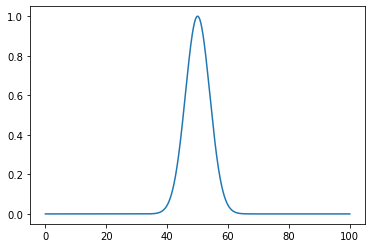

In [3]:
import matplotlib.pyplot as plt

y_axis = gaussian_function(x_axis, 1, 50, 4)

plt.plot(x_axis, y_axis)
plt.show()

However, in real life peaks are never this clean so we shall also add some *noise* to do this, let's create a function that calls our `gaussian_function`:

In [4]:
def noisy_gaussian_function(x_axis, a, b, c, noise_factor):
    length_of_x_axis = len(x_axis)
    noise_to_add = np.random.randn(length_of_x_axis) * noise_factor
    return gaussian_function(x_axis, a, b, c) + noise_to_add

In this function we first determine the length of the incoming `x_array` using `len()` (documentation: [len()](https://docs.python.org/3/library/functions.html#len)) then we generate an array of random numbers, using `numpy`s random number generator `random.randn()` (documentation: [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)), and then multiplying these values by a factor - so that we can tune the amount of noise.

We then take this array of noise and add it to the Gaussian function that we created earlier and:

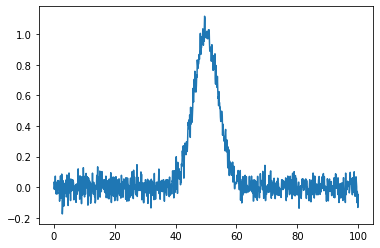

In [5]:
y_axis = noisy_gaussian_function(x_axis, 1, 50, 4, 0.05)

plt.plot(x_axis, y_axis)
plt.show()

Now we have some *noisy* data that we can fit. As we know that we have a Gaussian peak we can *cheat* slightly by using one of `lmfit`s in-built models - the `GaussianModel()` (documentation: [Built-in Fitting Models in lmfit](https://lmfit.github.io/lmfit-py/builtin_models.html))

In [6]:
from lmfit.models import *

gaussian_model = GaussianModel()
initial_guesses = gaussian_model.guess(data = y_axis, x = x_axis)
gaussian_fit = gaussian_model.fit(data = y_axis, params = initial_guesses, x = x_axis)

As can be seen above to use a built-in model, and the `lmfit` standard parameter guessing function, is relatively straightforward. Simply assign a `GaussianModel()` function, ask it to perform a guess of the initial parameters against your data (more on this in a bit) and then ask it to fit the data.

Question is... how did it do?

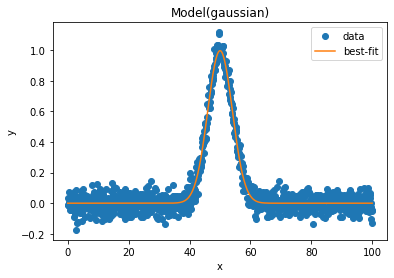

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1000
    # variables        = 3
    chi-square         = 2.38393677
    reduced chi-square = 0.00239111
    Akaike info crit   = -6033.00205
    Bayesian info crit = -6018.27879
[[Variables]]
    amplitude:  10.1056593 +/- 0.07170474 (0.71%) (init = 20.58422)
    center:     50.0285696 +/- 0.03309927 (0.07%) (init = 50.04702)
    sigma:      4.03986119 +/- 0.03309928 (0.82%) (init = 5.305305)
    fwhm:       9.51314593 +/- 0.07794284 (0.82%) == '2.3548200*sigma'
    height:     0.99794889 +/- 0.00708094 (0.71%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.577


In [7]:
gaussian_fit.plot_fit()
plt.show()
print(gaussian_fit.fit_report())

Looking at the fit to the data, and also the parameters - it did pretty well:

 - a = 1 / height = 0.99
 - b = 50 / center = 49.97
 - c = 4 / sigma = 4.05
 
It's worth noting that the values obtained above might vary *slightly* to the ones obtained when this is re-run as we're applying **random** noise to the input data. However, rounded to the nearest integer they are spot on their original values.

If you require to access the values in code, this can be achieved by retrieving the parameter dictionary from the fitted result which can be found in the `result` function under `params` from here you can then inspect and/or retrieve the fitted values *and* the bounds that might have been applied when fitting that parameter:

In [8]:
result_dictionary = gaussian_fit.result.params
print('Results Dictionary:')
print(result_dictionary)
print('\nFitted Amplitude:')
print(result_dictionary['amplitude'].value)

Results Dictionary:
Parameters([('amplitude', <Parameter 'amplitude', value=10.105659345853017 +/- 0.0717, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=50.028569589064055 +/- 0.0331, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=4.03986118946735 +/- 0.0331, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=9.513145926181506 +/- 0.0779, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=0.9979488881851051 +/- 0.00708, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>)])

Fitted Amplitude:
10.105659345853017


Which neatly brings us on to setting your own initial guesses *and* limits on the values to fit. Firstly we can call on the model to provide us with a parameter dictionary:

In [9]:
new_gaussian_model = GaussianModel()
initial_guesses = new_gaussian_model.make_params()

We can then have a look at the keys, either programatically or visually (as here):

In [10]:
print(initial_guesses.keys())

odict_keys(['amplitude', 'center', 'sigma', 'fwhm', 'height'])


Next we can set each of these keys using their `value`, `min` and `max` parameters - additionally by setting the `vary` boolean we can specify to `lmfit` whether a parameter should be fitted at all. For our existing dataset let's put in the following:

In [11]:
for key in initial_guesses.keys():
    initial_guesses[key].min = 0
    initial_guesses[key].max = 100

initial_guesses['height'].value = 1
initial_guesses['center'].value = 50
initial_guesses['center'].vary = False

To start with we've just iterated through all of the parameters and set the bounds to the bound of the dataset - perhaps not the best bound but better than +/- infinity.

Secondly we've seeded the height and center parameters with values of 1 and 50, respectively, and fixed the center value as, let's say, we know this up front. Now let's do a fit:

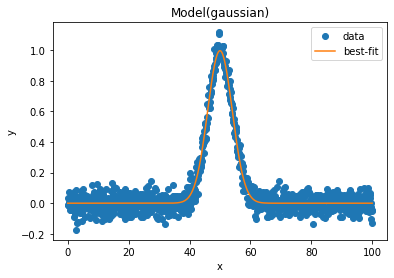

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 1000
    # variables        = 2
    chi-square         = 2.38571818
    reduced chi-square = 0.00239050
    Akaike info crit   = -6034.25508
    Bayesian info crit = -6024.43957
[[Variables]]
    amplitude:  10.1056035 +/- 0.07169611 (0.71%) (init = 1)
    center:     50 (fixed)
    sigma:      4.03991758 +/- 0.03309596 (0.82%) (init = 1)
    fwhm:       9.51327872 +/- 0.07793502 (0.82%) == '2.3548200*sigma'
    height:     0.99792945 +/- 0.00708000 (0.71%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.577


In [12]:
gaussian_fit = new_gaussian_model.fit(data = y_axis, params = initial_guesses, x = x_axis)

gaussian_fit.plot_fit()
plt.show()
print(gaussian_fit.fit_report())

Note in the parameter printout above it specifies what the starting values were (init = *x*) and, in the case of the center value, that it was fixed at a specific value.

For reference here, and more explicitly defined in the documentation here: [built-in models](https://lmfit.github.io/lmfit-py/builtin_models.html), the list of built-in models is:

 - GaussianModel
 - LorentzianModel
 - SplitLorentzianModel
 - VoigtModel
 - PseudoVoigtModel
 - MoffatModel
 - Pearson7Model
 - StudentsTModel
 - BreitWignerModel
 - LognormalModel
 - DampedOscillatorModel
 - DampedHarmonicOscillatorModel
 - ExponentialGaussianModel
 - SkewedGaussianModel
 - SkewedVoigtModel
 - ThermalDistributionModel
 - DoniachModel
 - ConstantModel
 - LinearModel
 - QuadraticModel
 - PolynomialModel
 - ineModel
 - StepModel
 - RectangleModel
 - ExponentialModel
 - PowerLawModel
 - Gaussian2dModel

Finally, we shall cover how to fit your own model using lmfit. Remembering the equation for a Gaussian from before we can create a custom `ExpressionModel` by instanciating an `ExpressionModel` object and providing it with the equation we wish to fit:

In [13]:
our_gaussian = ExpressionModel('a * exp(-(x - b)**2 / (2 * c**2))')

As you can see there are a number of 'reserved' keywords such as `x` and `exp`, however, you are free to utilise any non-mathematically common function name for your fitting variables - here I have picked `a`, `b` and `c` as in our data simulator class.

With that created we can then perform the fit and present the fit in the usual manner, with one *small* exception - the `guess()` function isn't available for custom models.

So, we must either call the `make_params()` function to generate a dictionary that we can then modify in the same way as we've just done, or we can explicitly pass to the `fit()` function the initial parameters that the fit should start with:

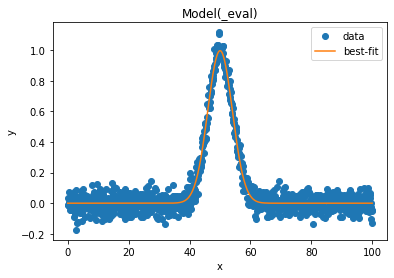

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1000
    # variables        = 3
    chi-square         = 2.38393677
    reduced chi-square = 0.00239111
    Akaike info crit   = -6033.00205
    Bayesian info crit = -6018.27879
[[Variables]]
    a:  0.99794883 +/- 0.00708095 (0.71%) (init = 1)
    b:  50.0285696 +/- 0.03309939 (0.07%) (init = 50)
    c:  4.03986129 +/- 0.03309939 (0.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.577


In [14]:
gaussian_fit = our_gaussian.fit(data = y_axis, x = x_axis, a = 1, b = 50, c = 1)

gaussian_fit.plot_fit()
plt.show()
print(gaussian_fit.fit_report())

As before, this yields a good fit!

## Saving Data